# Timeseries Forecast and Classification for Energy case

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

import sklearn
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from wildboar.distance import matrix_profile
from wildboar import annotate

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from sktime.transformations.panel.rocket import Rocket
from sklearn.linear_model import RidgeClassifierCV
from sklearn.preprocessing import LabelEncoder

## Load the dataset and check missing value

The dataset is taken from [Open Power System Data](https://data.open-power-system-data.org/time_series/). The timeframe of the dataset is between 1st January 2015 and 30th September 2020.

This data package contains different kinds of timeseries data relevant for power system modelling, namely electricity prices, electricity consumption (load) as well as wind and solar power generation and capacities. The data is aggregated either by country (*in this case we took only for Sweden*), control area or bidding zone. All variables are provided in hourly resolution.

**Variables:**
- SE_load_actual_entsoe_transparency:	Total load in Sweden in MW as published on ENTSO-E Transparency Platform
- SE_load_forecast_entsoe_transparency:	Day-ahead load forecast in Sweden in MW as published on ENTSO-E Transparency Platform
- SE_wind_capacity: Electrical capacity of wind in Sweden in MW	own calculation based on Vindbrukskollen
- SE_wind_offshore_capacity: Electrical capacity of wind_offshore in Sweden in MW (own calculation based on Vindbrukskollen)
- SE_wind_onshore_capacity: Electrical capacity of wind_onshore in Sweden in MW (own calculation based on Vindbrukskollen)
- SE_wind_onshore_generation_actual: Actual wind_onshore generation in Sweden in MW	ENTSO-E Transparency

**Bidding zone:**
Sweden's bidding zones in the electricity market are divided into:
- SE_1: Northern Sweden (lowest population, lots of hydro/wind generation)
- SE_2: Central Sweden
- SE_3: Southern Sweden (including Stockholm area)
- SE_4: Southernmost Sweden (including Malmö, connects to Denmark)

Each zone can have different electricity prices due to transmission constraints.

In this notebook, we'll be focusing on SE_3 data (individual zone) for better insights. The reason to keep the individual zones are:
- Different price dynamics: Each zone has different price patterns
- Regional load patterns: SE_3 (urban) vs SE_1 (industrial) have very different consumption
- Better model performance: Models can learn zone-specific patterns
- More realistic: Real electricity markets operate at zone level 

In [2]:
df = pd.read_csv('data/time_series_60min_singleindex_filtered.csv')[[
    'utc_timestamp',
    'SE_3_load_actual_entsoe_transparency',
    'SE_3_price_day_ahead',
    'SE_3_wind_onshore_generation_actual']]

In [3]:
# Ensure the data is in the right format
df[['SE_3_load_actual_entsoe_transparency',
'SE_3_price_day_ahead','SE_3_wind_onshore_generation_actual']] = df[['SE_3_load_actual_entsoe_transparency',
    'SE_3_price_day_ahead','SE_3_wind_onshore_generation_actual']].astype(float)

df.rename(columns = {
    'SE_3_load_actual_entsoe_transparency':'load_actual',
    'SE_3_price_day_ahead':'price',
    'SE_3_wind_onshore_generation_actual':'load_generation'
}, inplace=True)

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], errors='coerce')
df.set_index('utc_timestamp', inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 50401 entries, 2014-12-31 23:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   load_actual      50321 non-null  float64
 1   price            50386 non-null  float64
 2   load_generation  50303 non-null  float64
dtypes: float64(3)
memory usage: 1.5 MB


In [ ]:
df['load_generation'].plot(figsize=(16,8))

In [ ]:
df['load_generation'].plot(figsize=(16,8))

In [ ]:
df['price'].plot(figsize=(16,8))

In [ ]:
print("Missing value count")
print(df.isnull().sum())

In [ ]:
print("Missing value per columns")
print((df.isnull().mean()*100).round(3))

In [ ]:
for col in df.columns:
    na_blocks = df[col].isna().astype(int).groupby(df[col].notna().astype(int).cumsum()).sum()
    print(f"\nMissing blocks in {col}")
    print(na_blocks[na_blocks > 0])

# Interpretation:
# -. The tendency of missing values is a few very small gaps (likely hours)
# -. One moderate gap: 49 consecutive missing points (~ 2days)

## EDA + Feature Engineering

In [5]:
df_imp = df.copy()

def impute_ts(df):
    # Imputation of Missing Value
    max_gap_hours = 6
    period=24*7
        
    for column in df.columns:
        if df[column].isnull().sum() > 0:
            # Process each gap
            # print(f"Original dataset: {df[column].isnull().sum()}")

            i = 0
            missing_mask = df[column].isnull()

            while i < len(missing_mask):
                if missing_mask.iloc[i]:
                    gap_start = i # start of the gap
                    gap_end = i # end of the gap
                    while gap_end < len(missing_mask) - 1 and missing_mask.iloc[gap_end + 1]:
                        gap_end += 1
                    
                    gap_length_hours = gap_end - gap_start + 1
                    
                    # STEP 1: Short gaps - Linear interpolation
                    if gap_length_hours <= max_gap_hours:
                        df[column].iloc[gap_start:gap_end+1] = df[column].iloc[gap_start:gap_end+1].interpolate()
                        # print(f"After interpolation {i}: {df[column].iloc[gap_start:gap_end+1].isnull().sum()} NaNs")

                    # STEP 2: Medium gaps - Weekly pattern matching
                    else:
                        for j in range(gap_start, gap_end + 1):
                            current_time = df[column].index[j]
                            
                            # Look for same time in previous three weeks
                            for weeks_back in [1, 2, 3]:
                                past_time = current_time - pd.Timedelta(weeks=weeks_back)
                                if past_time in df[column].index and pd.notna(df[column].loc[past_time]):
                                    df[column].iloc[j] = df[column].loc[past_time]
                                    break
                            
                            # If it didn't work, use daily pattern
                            if pd.isna(df[column].iloc[j]):
                                for days_back in [1, 2, 3, 7]:
                                    past_time = current_time - pd.Timedelta(days=days_back)
                                    if past_time in df[column].index and pd.notna(df[column].loc[past_time]):
                                        df[column].iloc[j] = df[column].loc[past_time]
                                        break
                        
                        # Fill any remaining with interpolation
                        df[column].iloc[gap_start:gap_end+1] = df[column].iloc[gap_start:gap_end+1].interpolate()
                        # print(f"Final interpolation : {df[column].iloc[gap_start:gap_end+1].isnull().sum()}")
                    
                    i = gap_end + 1
                else:
                    i += 1
    
        # For the remaining NaNs
        try:
            decomposition = seasonal_decompose(df[column].dropna(), model='additive', period=period)
            trend = decomposition.trend.reindex(df[column].index)
            seasonal = decomposition.seasonal.reindex(series.index)

            missing_mask = df[column].isnull()
            for idx in df[column][missing_mask].index:
                if pd.notna(trend.loc[idx]) and pd.notna(seasonal.loc[idx]):
                    df[column].loc[idx] = trend.loc[idx] + seasonal.loc[idx]

            df[column] = df[column].interpolate()

        except Exception as e:
            df[column] = df[column].interpolate()

    return df

In [6]:
df_imp = impute_ts(df_imp)

In [7]:
# [BOUNDARY/ISOLATED CASES]: Remove problematic start period because the missing values are concentrated in the beginning of the data
first_valid_date = max(df_imp[col].first_valid_index() for col in df_imp.columns)
df_imp = df_imp.loc[first_valid_date:]

In [8]:
print(df_imp.isnull().sum())

load_actual        0
price              0
load_generation    0
dtype: int64


For the following analysis (check stationary, matrix profile, and motif discovery), you need to set a single variable that will be used multiple times.

Daily cycles: win = 24 --> Captures 1 full day
Multi-day cycles (weekend vs weekday): win = 24 * 7 = 168 --> Captures weekly structure
Seasonal templates (summer/winter): win = 24 * 30 ≈ 720 --> Captures monthly patterns
Load ramp patterns (morning/evening increase/decrease): win = 6–12 --> Shorter windows focus on ramp-up / ramp-down
Holiday / maintenance periods: win 24–168 -->Depends if anomaly is daily or spans a week

In [9]:
win = 24*7
lag = 30 # for check stationary, define the lag
win = 24*7 # period of recurring pattern (could be day, month, season)
exc = 0.2 # for matrix profile calc, avoid trivial matches (comparing a time period to itself or immediate neighbors)

### Check stationary

Investigate stationarity by:
- using a rolling mean and standard deviation: if both stay "approximately" constant over time the time series is likely stationary
- using a stationarity test such as Augmented Dickey-Fuller test
- by investing the auto-correlation for different time *lags*.

In [ ]:
def test_stationary(x, window=win, lags=lag):
    """Check stationarity using rolling statistics, ACF, and ADF test
    - rolling statistics: take a window and compute the mean and stdev within the window, then move on the window one time step
    - autocorrelation: how much the correlation between a time series and its lagged version of it
    lags: how many lagged version do we need to compute? showing by the number of bar represent in the chart
    - adf test: if ADF < 1%, 5%, 10% AND p-value < 1% --> reject H0 (non-stationary) --> this means the TS is stationary
    
    """

    roll_mean = x.rolling(window=window).mean()
    roll_std = x.rolling(window=window).std()

    fig, ax = plt.subplots(2, 1, figsize=(16, 12))

    # Rolling mean and std
    ax[0].plot(x, label="Original")
    ax[0].plot(roll_mean, label="Mean", linestyle='dashed')
    ax[0].plot(roll_std, label="Std Dev", linestyle='dotted')
    ax[0].legend()
    ax[0].set_title(f"Stationarity {x.name}: rolling mean and std dev, window={window}")

    # ACF plot
    plot_acf(x, lags=lags, ax=ax[1])
    ax[1].set_title(f"Stationarity ACF Plot {x.name}: Autocorrelation for lags={lags}")

    result = adfuller(x)
    print(f"ADF Test Results:{x}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")

    return fig, ax

In [ ]:
test_stationary(df_imp['load_actual'])

# Interpretation: the timeseries is stationary

In [ ]:
test_stationary(df_imp['price'])

# Interpretation: the timeseries is stationary

In [ ]:
test_stationary(df_imp['load_generation'])

# Interpretation: the timeseries is stationary

### Decomposition

In [ ]:
def decompose_series(x, model='additive', period=win):
    """Decompose the series into trend, seasonality, and residuals."""

    decomposition = seasonal_decompose(x, model=model, period=period)
    
    fig, ax = plt.subplots(nrows=4, figsize=(12, 12))
        
    ax[0].plot(x.index, x)
    ax[0].set_ylabel("Original")
    ax[1].plot(decomposition.trend)
    ax[1].set_ylabel("Trend")
    ax[2].plot(decomposition.seasonal)
    ax[2].set_ylabel("Seasonality")
    ax[3].plot(decomposition.resid)
    ax[3].set_ylabel("Residuals")
    fig.tight_layout()
    return fig, ax

In [ ]:
decompose_series(df_imp['load_actual'])

In [ ]:
decompose_series(df_imp['load_generation'])

In [ ]:
decompose_series(df_imp['price'])

### Matrix Profile using MASS for faster implementation

It helps us to understand: 
- recurring daily patterns: which days had similar load curve
- seasonal similarities: find similar weeks/months across different year
- anomaly detection: high matrix profile value = unusual periods with no similar pattern
- pattern stability: low values = recurring, predictable patterns

Two parts represent: <br> 
-. minimum distance of every possible query of window size <br>
-. index of the time series with the closest counterparts. <br>


In [ ]:
def compute_matrix_profile(x, window=win, exclude=exc, return_index=True, top_k=5):
    start = time.time()
    mp, mp_idx = matrix_profile(x, window=window, exclude=exclude, return_index=True)

    fig, ax= plt.subplots(2, figsize=(16,12))
    ax[0].plot(mp)
    ax[0].set_title("Matrix Profile")
    ax[1].plot(x.index, x.values, label="Original", color='gray', alpha=0.7)

    # Find most recurring patterns (lowest MP values)
    min_idx = np.argsort(mp)[:top_k]  # Top 5 most similar patterns
    
    colors = ["red", "green", "orange", "purple", "blue"]
    print(f"Most recurring patterns (lowest distances):")

    for j, idx in enumerate(min_idx):
        if not np.isnan(mp[idx]):
            partner_idx = mp_idx[idx]
            pattern_time = x.index[idx]
            partner_time = x.index[partner_idx]

            pattern_time_num = mdates.date2num(pattern_time)
            partner_time_num = mdates.date2num(partner_time)

            time_width = mdates.date2num(pattern_time + pd.Timedelta(hours=window)) - pattern_time_num

            # Highlight subsequences on plot
            ax[1].add_patch(Rectangle((pattern_time_num, x.iloc[idx]),   # rectangle at motif start
                                      time_width, (x.max() - x.min()) * 0.1, # matplotlib needs the actual time span on the x-axis.
                                      linewidth=3, edgecolor=colors[j % len(colors)],
                                      facecolor=colors[j % len(colors)], alpha=0.3,
                                      label=f'Motif {j+1}'))
            ax[1].add_patch(Rectangle((partner_time_num, x.iloc[partner_idx]),
                                      time_width, (x.max() - x.min()) * 0.1,
                                      linewidth=3, edgecolor=colors[j % len(colors)],
                                      facecolor=colors[j % len(colors)], alpha=0.3))

            # Print info
            pattern_date = x.index[idx]
            partner_date = x.index[partner_idx] if partner_idx < len(x) else "N/A"
            print(f"  {j+1}. {pattern_date} (distance: {mp[idx]:.2f}, similar to: {partner_date})")

    ax[1].set_title("Original Series with Highlighted Motifs")
    ax[1].legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Execution time: {time.time() - start:.2f} secs")
    return mp, mp_idx

In [ ]:
mp_load, mp_idx_load = compute_matrix_profile(df_imp['load_actual'], window=win, exclude=exc)

In [ ]:
mp_gen, mp_idx_gen = compute_matrix_profile(df_imp['load_generation'])

In [ ]:
mp_price, mp_idx_gen = compute_matrix_profile(df_imp['price'])

### Motif discovery

It represents:
- typical daily cycles: weekend vs. weekdays
- seasonal templates: standard summer / winter consumption curves
- event patterns: holiday consumption/maintenance period
- load ramp patterns: how consumption typically increases/decreases 

Therefore, motif discovery helps energy company to capacity planning, anomaly detection (deviations from motif), or pricing strategies.

Mechanism:
1. Note that those points that minimize the MatrixProfile have a close counterpart somewhere else.
2. Start with the smallest, `mp`-value and search for all subsequences close to it.
    - Exclude those that are far away (user tunable threshold)


In [ ]:
all_motifs = []
for series in df_imp.T.values: 
    motifs = annotate.motifs(series, window=win, max_distance=1, max_motif=3, min_neighbours=2)
    all_motifs.append(motifs)

In [ ]:
fig, ax = plt.subplots(nrows=len(df_imp.columns), figsize=(12, 3*len(df_imp.columns)))
for i, col in enumerate(df_imp.columns):
    ax[i].plot(df_imp.index, df_imp[col], color="gray", lw=0.5)
    ax[i].set_title(str(col))

def plot_motifs(X, all_motifs, *, ax, window):
    cmap = plt.get_cmap("Dark2", len(all_motifs))
    for j, motifs in enumerate(all_motifs):
        for motif in motifs:
            time_idx = df_imp.index[motif:motif+window]
            ax.plot(time_idx, X[motif:motif+window], color=cmap(j), lw=3)

for i, col in enumerate(df_imp.columns):
    plot_motifs(df_imp[col].values, all_motifs[i], ax=ax[i], window=win)

fig.tight_layout()
plt.show()


### Seasonal Analysis

Analyze how patterns vary by season, day of week, etc.

In [ ]:
df_analysis = df_imp.copy()
column = 'load_actual'
df_analysis.index = pd.to_datetime(df_analysis.index)
df_analysis['hour'] = df_analysis.index.hour
df_analysis['day_of_week'] = df_analysis.index.dayofweek
df_analysis['month'] = df_analysis.index.month
df_analysis['season'] = df_analysis['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring', 
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily patterns by season
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    season_data = df_analysis[df_analysis['season'] == season]
    daily_pattern = season_data.groupby('hour')[column].mean()
    axes[0,0].plot(daily_pattern.index, daily_pattern.values, 
                    label=season, linewidth=2)

axes[0,0].set_title('Daily Load Pattern by Season')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Average Load')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Weekly patterns
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekly_pattern = df_analysis.groupby('day_of_week')[column].mean()
axes[0,1].bar(range(7), weekly_pattern.values)
axes[0,1].set_title('Average Load by Day of Week')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(days)
axes[0,1].set_ylabel('Average Load')

# Monthly patterns
monthly_pattern = df_analysis.groupby('month')[column].mean()
axes[1,0].plot(monthly_pattern.index, monthly_pattern.values, 'o-', linewidth=2)
axes[1,0].set_title('Average Load by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Average Load')
axes[1,0].grid(True, alpha=0.3)

# Heatmap of hour vs day of week
pivot_data = df_analysis.pivot_table(values=column, index='hour', 
                                    columns='day_of_week', aggfunc='mean')
sns.heatmap(pivot_data, ax=axes[1,1], cmap='YlOrRd', 
            xticklabels=days, cbar_kws={'label': 'Average Load'})
axes[1,1].set_title('Load Heatmap: Hour vs Day of Week')

plt.tight_layout()
plt.show()

In [ ]:
# Print insights
print("Key Insights:")
peak_season = monthly_pattern.idxmax()
low_season = monthly_pattern.idxmin()
print(f"- Peak consumption month: {peak_season}")
print(f"- Lowest consumption month: {low_season}")

peak_day = weekly_pattern.idxmax()
low_day = weekly_pattern.idxmin()
print(f"- Highest consumption day: {days[peak_day]}")
print(f"- Lowest consumption day: {days[low_day]}")

daily_avg = df_analysis.groupby('hour')[column].mean()
peak_hour = daily_avg.idxmax()
low_hour = daily_avg.idxmin()
print(f"- Peak consumption hour: {peak_hour:02d}:00")
print(f"- Lowest consumption hour: {low_hour:02d}:00")

## Forecast

Outline:
1. Train-test split
2. ARIMA
3. N-BEATS
4. LSTM Forecasting
5. Timeseries Classification with Rocket

**For simplicity, we'll use 'load_actual' as the target. However, it's possible to modify the code based on the needs.**

### 0. Evaluation

For comparison between model

In [10]:
def evaluate_forecasts(predictions, actuals, model_name="Model"):
    """
    Evaluate forecasting performance
    """
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100
    
    print(f"\n{model_name} Performance:")
    print(f"  MAE:  {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  MAPE: {mape:.2f}%")
    
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

def plot_forecasts(predictions, actuals, model_name="Model", n_show=24*7):
    """
    Plot forecast results
    """
    plt.figure(figsize=(15, 6))
    
    # Show only first n_show points for clarity
    show_pred = predictions[:n_show]
    show_actual = actuals[:n_show]
    
    plt.plot(show_actual, label='Actual', linewidth=2)
    plt.plot(show_pred, label=f'{model_name} Prediction', linewidth=2, alpha=0.8)
    plt.title(f'{model_name} Forecast vs Actual')
    plt.xlabel('Hours')
    plt.ylabel('Load')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


### 1. Train-test split

Estimation: <br>
Training: 70% (2015 - mid 2018) <br>
Validation: 10% (mid 2018 - early 2019) <br>
Test: 20% (early 2019 - 2020) <br>

In [11]:
class TimeSeriesTrainTest:
    """
    Proper time series data splitting and preparation
    """
    
    def __init__(self, df, target_col='load_actual', test_size=0.3, val_size=0.1):
        self.df = df.copy()
        self.target_col = target_col
        self.test_size = test_size
        self.val_size = val_size
        
    def temporal_split(self):
        """
        Split data temporally, respect the sequence
        """
        
        total_len = len(self.df)
        
        # Calculate split points
        train_end = int(total_len * (1 - self.test_size - self.val_size))
        val_end = int(total_len * (1 - self.test_size))
        
        # Split the data
        train_data = self.df.iloc[:train_end]
        val_data = self.df.iloc[train_end:val_end]
        test_data = self.df.iloc[val_end:]
        
        print(f"Training data: {train_data.index[0]} to {train_data.index[-1]} ({len(train_data)} points)")
        print(f"Validation data: {val_data.index[0]} to {val_data.index[-1]} ({len(val_data)} points)")
        print(f"Test data: {test_data.index[0]} to {test_data.index[-1]} ({len(test_data)} points)")
        
        # Visualize split
        plt.figure(figsize=(15, 6))
        plt.plot(train_data.index, train_data[self.target_col], label='Train', alpha=0.7)
        plt.plot(val_data.index, val_data[self.target_col], label='Validation', alpha=0.7)
        plt.plot(test_data.index, test_data[self.target_col], label='Test', alpha=0.7)
        plt.title('Time Series Data Split')
        plt.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        return train_data, val_data, test_data
    
    def create_sequences(self, data, lookback_window=win, forecast_horizon=24):
        """
        Create sequences for deep learning models
        """
        X, y = [], []
        
        for i in range(lookback_window, len(data) - forecast_horizon + 1):
            # Features: past 'lookback_window' hours
            X.append(data.iloc[i-lookback_window:i].values)
            # Target: next 'forecast_horizon' hours
            y.append(data[self.target_col].iloc[i:i+forecast_horizon].values)
        
        return np.array(X), np.array(y)

Training data: 2015-01-05 00:00:00+00:00 to 2018-06-15 13:00:00+00:00 (30182 points)
Validation data: 2018-06-15 14:00:00+00:00 to 2019-01-11 03:00:00+00:00 (5030 points)
Test data: 2019-01-11 04:00:00+00:00 to 2020-09-30 23:00:00+00:00 (15092 points)


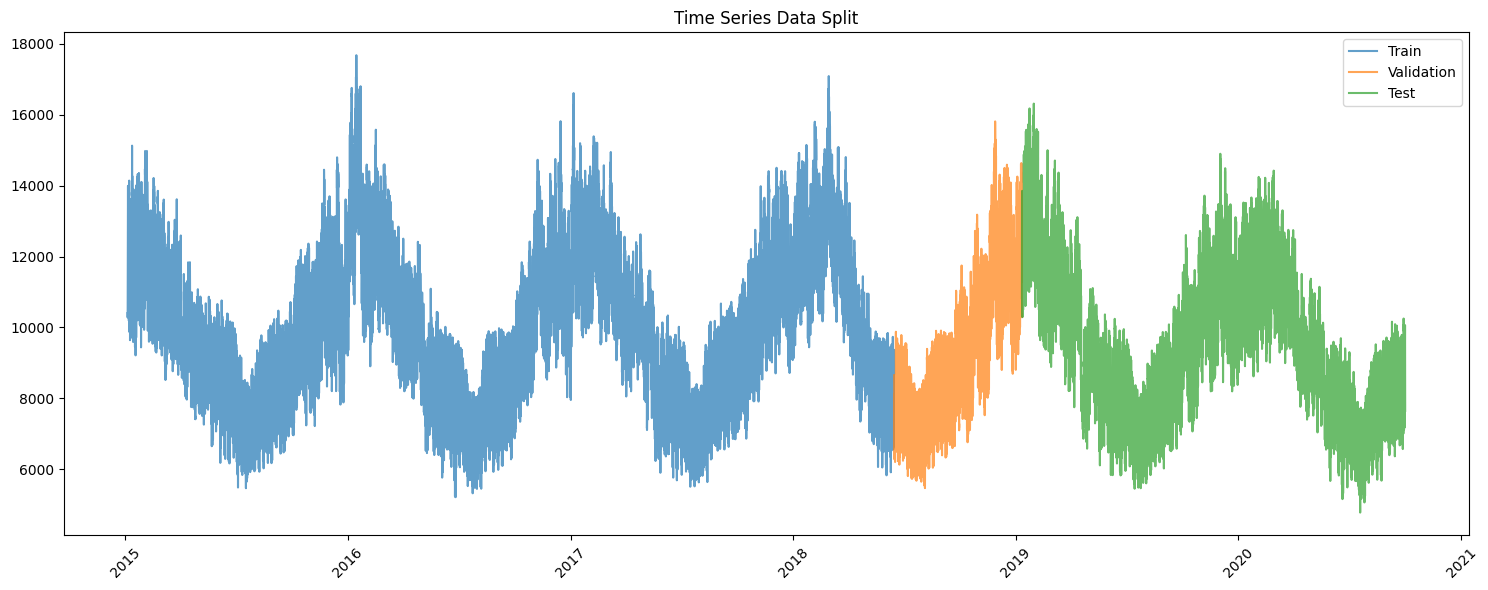

In [12]:
data_handler_imp = TimeSeriesTrainTest(df_imp, target_col='load_actual')
train_data_imp, val_data_imp, test_data_imp = data_handler_imp.temporal_split()

Training data: 2014-12-31 23:00:00+00:00 to 2018-06-13 22:00:00+00:00 (30240 points)
Validation data: 2018-06-13 23:00:00+00:00 to 2019-01-09 22:00:00+00:00 (5040 points)
Test data: 2019-01-09 23:00:00+00:00 to 2020-09-30 23:00:00+00:00 (15121 points)


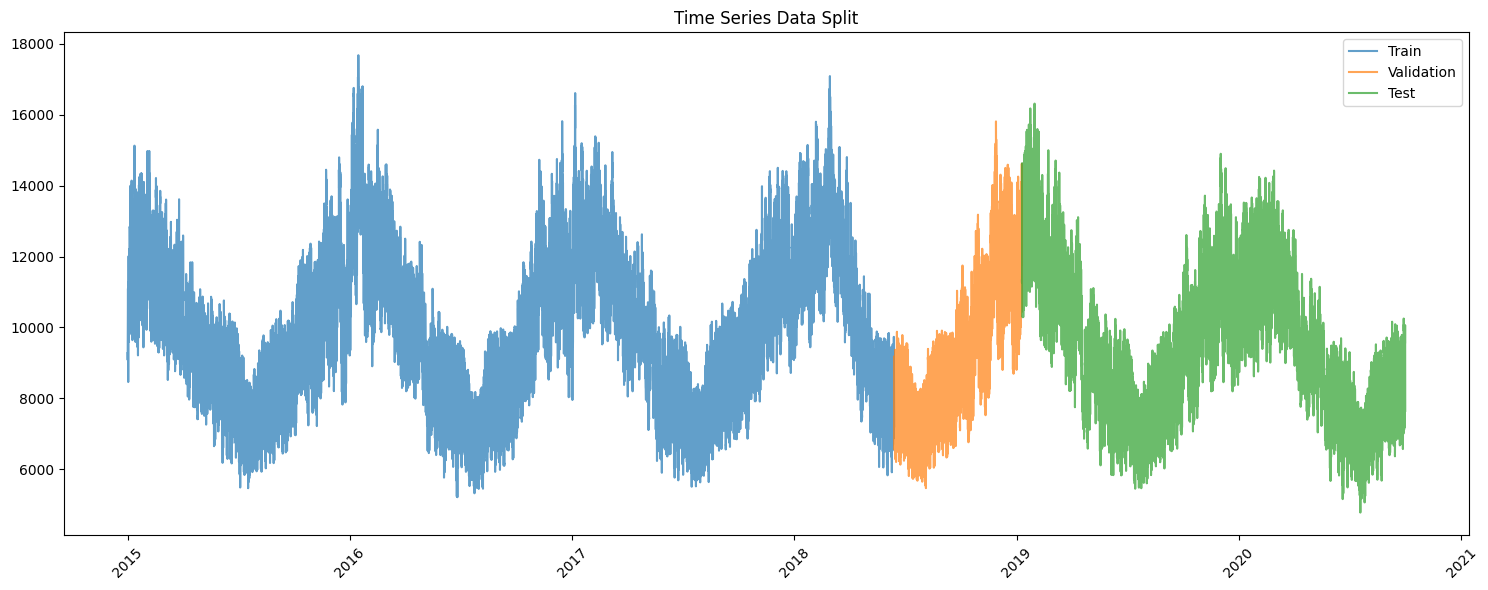

In [13]:
data_handler = TimeSeriesTrainTest(df, target_col='load_actual')
train_data, val_data, test_data = data_handler.temporal_split()

### 2. ARIMA

Statistical model, good baseline, captures trends/seasonality

In [ ]:
class ARIMAForecast:
    """
    ARIMA model for time series forecasting
    """
    
    def __init__(self):
        self.model = None
        self.model_fit = None
        
    def fit(self, train_data, target_col='load_actual', order=(1,1,1)):
        """
        Fit ARIMA model
        """
        
        series = train_data[target_col].dropna()
        
        # Fit model
        self.model = ARIMA(series, order=order)
        self.model_fit = self.model.fit()
        
        print(self.model_fit.summary())
        
        return self
    
    def forecast_rolling(self, test_data, target_col='load_actual', forecast_horizon=24):
        """
        Rolling forecast (refit model for each prediction)
        """
        print(f"=== ARIMA ROLLING FORECAST (horizon: {forecast_horizon} hours) ===")
        
        predictions = []
        actuals = []
        
        # Get initial training data
        history = list(self.model_fit.fittedvalues)
        
        for i in range(0, len(test_data) - forecast_horizon + 1, forecast_horizon):
            # Forecast next 'forecast_horizon' hours
            forecast = self.model_fit.forecast(steps=forecast_horizon)
            predictions.extend(forecast)
            
            # Get actual values
            actual = test_data[target_col].iloc[i:i+forecast_horizon].values
            actuals.extend(actual)
            
            # Update history with actual values for next iteration
            history.extend(actual)
            
            # Refit model with updated data (optional - computationally expensive)
            # For long series, you might skip this step
            
            if i % (forecast_horizon * 7) == 0:  # Print progress every week
                print(f"Forecasted {i + forecast_horizon} / {len(test_data)} hours")
        
        return np.array(predictions), np.array(actuals)
    
    def forecast_simple(self, n_periods=24):
        """
        Simple forecast without rolling
        """
        return self.model_fit.forecast(steps=n_periods)

In [ ]:
arima_model = ARIMAForecast()
arima_model.fit(train_data_imp, target_col='load_actual')
arima_pred, arima_actual = arima_model.forecast_rolling(test_data_imp, target_col='load_actual')
arima_metrics = evaluate_forecasts(arima_pred, arima_actual, "ARIMA")
plot_forecasts(arima_pred, arima_actual, "ARIMA")

### 3. N-BEATS: Neural network designed for forecasting, handles complex patterns

*Using KERAS*

Keras version gives easy multi-step forecasting, with preprocessing and training handled automatically, better for applied forecasting pipelines. However, if we are in a research or experimenting with complex architectures, PyTorch version gives full manual control.

In [ ]:
class NBEATSForecast:
    """
    N-BEATS neural network for forecasting
    """
    
    def __init__(self, lookback_window=24*7, forecast_horizon=24):
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon
        self.model = None
        self.scaler = StandardScaler()
        
    def create_model(self, input_dim):
        """
        Create N-BEATS-inspired model using Keras
        """
        
        model = Sequential([
            Input(shape=(self.lookback_window, input_dim)),
            Flatten(),
            Dense(512, activation='relu'),
            Dropout(0.2),
            Dense(256, activation='relu'),
            Dropout(0.2),
            Dense(128, activation='relu'),
            Dense(self.forecast_horizon)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001), 
                     loss='mse', 
                     metrics=['mae'],
                     clipnorm=1.0 # gradient clipping
                     )
        
        return model
    
    def fit(self, train_data, val_data, target_col='load_actual', epochs=50):
        """
        Train N-BEATS model
        """
        
        # Prepare data
        data_handler = TimeSeriesTrainTest(pd.concat([train_data, val_data]))
        
        # Create sequences
        X_train, y_train = data_handler.create_sequences(
            train_data, self.lookback_window, self.forecast_horizon
        )
        X_val, y_val = data_handler.create_sequences(
            val_data, self.lookback_window, self.forecast_horizon
        )
        
        # Scale data - reshape to 2D for scaler, then back to 3D
        X_train_2d = X_train.reshape(-1, X_train.shape[-1])
        X_val_2d = X_val.reshape(-1, X_val.shape[-1])
        
        X_train_scaled_2d = self.scaler.fit_transform(X_train_2d)
        X_val_scaled_2d = self.scaler.transform(X_val_2d)

        X_train_scaled = X_train_scaled_2d.reshape(X_train.shape)
        X_val_scaled = X_val_scaled_2d.reshape(X_val.shape)
        
        # Create and train model
        self.model = self.create_model(X_train.shape[-1])
        
        history = self.model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs,
            batch_size=32,
            verbose=1
        )
        
        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train')
        plt.plot(history.history['val_loss'], label='Validation')
        plt.title('Model Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Train')
        plt.plot(history.history['val_mae'], label='Validation')
        plt.title('Model MAE')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        return self
    
    def forecast_rolling(self, test_data, target_col='load_actual'):
        """
        Rolling forecast with N-BEATS
        """
        print("=== N-BEATS ROLLING FORECAST ===")

        predictions = []
        actuals = []

        # Include tail of training data for the first lookback
        data_for_prediction = pd.concat([train_data.iloc[-self.lookback_window:], test_data], ignore_index=True)

        start_idx = self.lookback_window  # start predicting after training tail

        for i in range(start_idx, len(data_for_prediction) - self.forecast_horizon + 1, self.forecast_horizon):
            lookback_data = data_for_prediction.iloc[i - self.lookback_window:i]

            # safety check
            if len(lookback_data) < self.lookback_window:
                continue

            X_pred = lookback_data.values.reshape(1, self.lookback_window, -1)
            X_pred_scaled = self.scaler.transform(X_pred.reshape(-1, X_pred.shape[-1])).reshape(X_pred.shape)

            pred = self.model.predict(X_pred_scaled, verbose=0)[0]
            predictions.extend(pred)

            actual_idx_start = i - self.lookback_window
            actual = test_data[target_col].iloc[actual_idx_start:actual_idx_start + self.forecast_horizon].values
            actuals.extend(actual)

        return np.array(predictions), np.array(actuals)


In [ ]:
nbeats_model = NBEATSForecast()
nbeats_model.fit(train_data_imp, val_data_imp, target_col='load_actual', epochs=20)  # Reduced for demo
nbeats_pred, nbeats_actual = nbeats_model.forecast_rolling(test_data, target_col='load_actual')
nbeats_metrics = evaluate_forecasts(nbeats_pred, nbeats_actual, "N-BEATS")
plot_forecasts(nbeats_pred, nbeats_actual, "N-BEATS")

### LSTM: RNN for sequential data, captures long-term dependencies

*Using KERAS/TF LSTM*

Keras version gives easy multi-step forecasting, with preprocessing and training handled automatically, better for applied forecasting pipelines. However, if we are in a research or experimenting with complex architectures, PyTorch version gives full manual control.

This model utilize "multi-steps" (forecast_horizon). Comparison between single step and multi steps:<br>
**1. One-step-ahead prediction (recursive / iterated)**
How it works:
- Model predicts one timestep ahead.
- Feed that prediction as input to predict the next timestep.
- Repeat until you reach your forecast horizon.

Pros:
- Simpler model — only needs to learn one-step dynamics.
- Often easier to train, less prone to exploding errors in training.
- Works well if the series is smooth or stationary.

Cons:
- Errors accumulate (propagate) over multiple steps — a small mistake in early predictions can ruin later steps.
- Prediction distribution may drift from reality over long horizons.

Use case:
- Short-term forecasts.
- When the system dynamics are fairly stable and predictable.

**2. Multi-step prediction at each step (direct + rolling)**
How it works:
- Model predicts multiple steps at each time step, potentially with overlapping windows.
- Can be thought of as a hybrid: each forecast covers multiple steps, but you also move forward in time.

Pros:
- Balances flexibility and horizon coverage.
- Can learn inter-step correlations better than simple recursive one-step.

Cons:
- Even harder to train.
- Can be computationally expensive if horizon is long.

In [ ]:
class LSTMForecast:
    """
    LSTM model for time series forecasting
    """
    
    def __init__(self, lookback_window=24*7, forecast_horizon=24):
        self.lookback_window = lookback_window
        self.forecast_horizon = forecast_horizon
        self.model = None
        self.scaler = StandardScaler()
    
    def create_model(self, input_dim):
        """
        Create LSTM model
        """
        
        model = Sequential([
            LSTM(100, return_sequences=True, input_shape=(self.lookback_window, input_dim)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(self.forecast_horizon)
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae'],
                     clipnorm=1.0 # gradient clipping
                     )
        
        return model
    
    def fit(self, train_data, val_data, target_col='load_actual', epochs=50):
        """
        Train LSTM model
        """
        print("=== TRAINING LSTM MODEL ===")
        
        # Create sequences
        data_handler = TimeSeriesTrainTest(pd.concat([train_data, val_data]))
        X_train, y_train = data_handler.create_sequences(
            train_data, self.lookback_window, self.forecast_horizon
        )
        X_val, y_val = data_handler.create_sequences(
            val_data, self.lookback_window, self.forecast_horizon
        )
        
        # Scale data
        X_train_scaled = self.scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = self.scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        
        # Create and train model
        self.model = self.create_model(X_train.shape[-1])
        
        history = self.model.fit(
            X_train_scaled, y_train,
            validation_data=(X_val_scaled, y_val),
            epochs=epochs,
            batch_size=32,
            verbose=1
        )
        
        return self
    
    def forecast_rolling(self, test_data, target_col='load_actual'):
        """
        Rolling forecast with LSTM
        """
        print("=== LSTM ROLLING FORECAST ===")
        
        predictions = []
        actuals = []
        
        for i in range(0, len(test_data) - self.forecast_horizon + 1, self.forecast_horizon):
            # Prepare input sequence
            if i == 0:
                lookback_data = test_data.iloc[i:i+self.lookback_window]
            else:
                lookback_data = test_data.iloc[i-self.lookback_window:i]
            
            X_pred = lookback_data.values.reshape(1, self.lookback_window, -1)
            X_pred_scaled = self.scaler.transform(X_pred.reshape(-1, X_pred.shape[-1])).reshape(X_pred.shape)
            
            # Make prediction
            pred = self.model.predict(X_pred_scaled, verbose=0)[0]
            predictions.extend(pred)
            
            # Get actual values
            actual = test_data[target_col].iloc[i:i+self.forecast_horizon].values
            actuals.extend(actual)
        
        return np.array(predictions), np.array(actuals)

In [ ]:
lstm_model = LSTMForecast()
lstm_model.fit(train_data_imp, val_data_imp, target_col='load_actual', epochs=20)
lstm_pred, lstm_actual = lstm_model.forecast_rolling(test_data_imp, target_col='load_actual')
lstm_metrics = evaluate_forecasts(lstm_pred, lstm_actual, "LSTM")
plot_forecasts(lstm_pred, lstm_actual, "LSTM")

### Rocket: Fast time series classification using random convolutions

*Identify consumption patterns (High/Medium/Low usage periods)*

In [ ]:
class TimeSeriesClassifier:
    """
    Time series classification using ROCKET
    """
    
    def __init__(self, window_size=24*7):
        self.window_size = window_size
        self.rocket = None
        self.classifier = None
        
    def create_classification_data(self, df, target_col='load_actual'):
        """
        Create classification dataset from time series
        Example: Classify consumption patterns (High/Medium/Low)
        """
        print("=== CREATING CLASSIFICATION DATASET ===")
        
        X_class = []
        y_class = []
        
        for i in range(0, len(df) - self.window_size + 1, self.window_size):
            # Get window of data
            window = df[target_col].iloc[i:i+self.window_size].values
            
            # Create label based on average consumption
            avg_consumption = np.mean(window)
            if avg_consumption > np.percentile(df[target_col], 75):
                label = 'High'
            elif avg_consumption > np.percentile(df[target_col], 25):
                label = 'Medium'
            else:
                label = 'Low'
            
            X_class.append(window)
            y_class.append(label)
        
        print(f"Created {len(X_class)} classification samples")
        print(f"Class distribution: \n{pd.Series(y_class).value_counts()}")
        
        return np.array(X_class), np.array(y_class)
    
    def fit_rocket(self, X_train, y_train):
        """
        Train ROCKET classifier
        """
        print("=== TRAINING ROCKET CLASSIFIER ===")
        
        # Initialize ROCKET
        self.rocket = Rocket()
        
        # Fit ROCKET and transform training data
        X_train_rocket = X_train[:, np.newaxis, :]  # shape (n_samples, 1, window_size)
        X_rocket = self.rocket.fit_transform(X_train_rocket)
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y_train)
        
        # Train classifier
        self.classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
        self.classifier.fit(X_rocket, y_encoded)
        
        print("ROCKET classifier trained successfully")

    def predict(self, X_test):
        """
        Make predictions
        """
        
        # ROCKET predictions
        X_rocket = self.rocket.transform(X_test[:, np.newaxis, :])
        predictions = self.classifier.predict(X_rocket)
        
        return self.label_encoder.inverse_transform(predictions)

In [18]:
classifier = TimeSeriesClassifier()
X_class, y_class = classifier.create_classification_data(df_imp, target_col='load_actual')

# Split classification data
n_train = int(len(X_class) * 0.8)
X_train_class, X_test_class = X_class[:n_train], X_class[n_train:]
y_train_class, y_test_class = y_class[:n_train], y_class[n_train:]

classifier.fit_rocket(X_train_class, y_train_class)
class_pred = classifier.predict(X_test_class)

from sklearn.metrics import classification_report
print("Classification Results:")
print(classification_report(y_test_class, class_pred))


=== CREATING CLASSIFICATION DATASET ===
Created 299 classification samples
Class distribution: Medium    154
High       81
Low        64
Name: count, dtype: int64
=== TRAINING ROCKET CLASSIFIER ===
ROCKET classifier trained successfully
Classification Results:
              precision    recall  f1-score   support

        High       0.63      0.92      0.75        13
         Low       0.91      0.62      0.74        16
      Medium       0.77      0.74      0.75        31

    accuracy                           0.75        60
   macro avg       0.77      0.76      0.75        60
weighted avg       0.78      0.75      0.75        60



## Conclusion

In [19]:
comparison = pd.DataFrame({
        'Model': ['ARIMA', 'N-BEATS', 'LSTM'],
        'MAE': [arima_metrics['MAE'], nbeats_metrics['MAE'], lstm_metrics['MAE']],
        'RMSE': [arima_metrics['RMSE'], nbeats_metrics['RMSE'], lstm_metrics['RMSE']],
        'MAPE': [arima_metrics['MAPE'], nbeats_metrics['MAPE'], lstm_metrics['MAPE']]
    })
    
print("Final Comparison")
print(comparison)

NameError: name 'arima_metrics' is not defined